# Naive Forecasting Models

### Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import r2_score,mean_absolute_percentage_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set_style("whitegrid")
sns.color_palette("coolwarm")

[(0.4044212904941176, 0.5346434904470588, 0.9320019126352941),
 (0.603162067917647, 0.7315274773529412, 0.9995652785372549),
 (0.7867207013568628, 0.8448072103686275, 0.9398103849490196),
 (0.9306685963333333, 0.818876999654902, 0.7591463906980392),
 (0.9673165156666667, 0.6574708288078431, 0.5381601507294118),
 (0.8846434386941177, 0.41001709788235297, 0.32250654924705885)]

In [3]:
#Reading data
df_ts = pd.read_csv("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/data/prepared_ts_data.csv", parse_dates=["date"], index_col="date")

In [4]:
#Loading data
#df_ts = pd.read_parquet("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast//data/df_ts_checkpoint4.parquet")

In [5]:
#Filtering for Jan-Mar 2014
df_ts = df_ts[df_ts.index < "2014-04-01"]

In [6]:
df_ts.to_parquet("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/data/df_ts_checkpoint4.parquet")
print("Checkpoint 4 saved successfully!")

Checkpoint 4 saved successfully!


In [8]:
df_ts.head()

,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_log,is_outlier,year,month,day,day_of_week,unit_sales_7d_avg,is_holiday,dcoilwtico,family
date,,,,,,,,,,,,,,
2013-01-02,24,105574,12.00,0.00,2.56,False,2013,1,2,2,NaN,0,93.14,GROCERY I
2013-01-03,24,105574,1.00,0.00,0.69,False,2013,1,3,3,NaN,0,92.97,GROCERY I
2013-01-04,24,105574,3.00,0.00,1.39,False,2013,1,4,4,NaN,0,93.12,GROCERY I
2013-01-05,24,105574,4.00,0.00,1.61,False,2013,1,5,5,NaN,0,93.12,GROCERY I
2013-01-06,24,105574,7.00,0.00,2.08,False,2013,1,6,6,NaN,0,93.12,GROCERY I


In [9]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9437752 entries, 2013-01-02 to 2014-03-31
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   store_nbr          int64  
 1   item_nbr           int64  
 2   unit_sales         float64
 3   onpromotion        float64
 4   unit_sales_log     float64
 5   is_outlier         bool   
 6   year               int64  
 7   month              int64  
 8   day                int64  
 9   day_of_week        int64  
 10  unit_sales_7d_avg  float64
 11  is_holiday         int64  
 12  dcoilwtico         float64
 13  family             object 
dtypes: bool(1), float64(5), int64(7), object(1)
memory usage: 1017.1+ MB


### Naive Forecasting Model

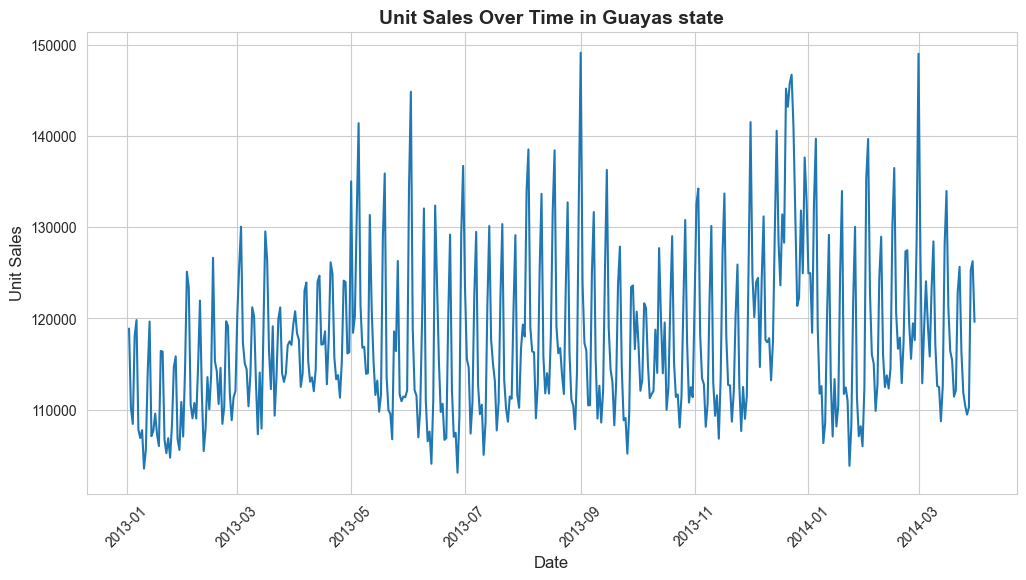

In [10]:
#Aggregate unit sales by day
df_daily_sales = df_ts.groupby(df_ts.index).agg({"unit_sales": "sum"})

#Plotting the time-series, first with unit sales
plt.figure(figsize=(12,6))
plt.plot(df_daily_sales.index, df_daily_sales["unit_sales"])
plt.title('Unit Sales Over Time in Guayas state', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

In [11]:
#Converting to a Pandas Series for modelling
ts = df_daily_sales["unit_sales"]

In [12]:
#Defining the split date based on forecast target
split_date = "2014-01-01"

#Creating train and test sets
train = ts[:split_date]
test = ts[split_date:"2014-03-31"]

In [13]:
#Fitting model
naive_forecast = pd.Series([train.iloc[-1]] * len(test), index=test.index)

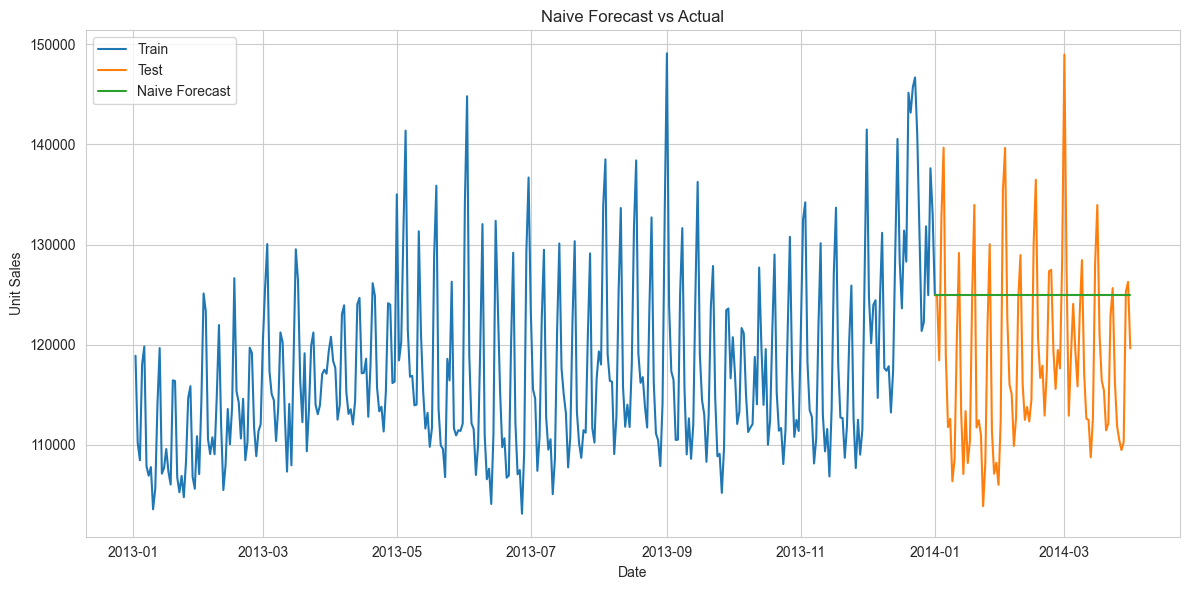

In [14]:
#Plotting prediction
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train", color="#1f77b4")
plt.plot(test.index, test, label="Test", color="#ff7f0e")
plt.plot(naive_forecast.index, naive_forecast, label="Naive Forecast", color="#2ca02c")
plt.legend()
plt.title("Naive Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
#Evaluating forecast
r2 = r2_score(test, naive_forecast)
mape = mean_absolute_percentage_error(test, naive_forecast)

print(f"Naive R2 Score: {r2:.4f}")
print(f"Naive MAPE: {mape*100:.2f}%")

Naive R2 Score: -0.4914
Naive MAPE: 8.09%


This naive model will act as a baseline for future iterations and models.

### Triple Exponential Smoothing (Holt-Winter)

In [16]:
#Fitting model
hw_model = ExponentialSmoothing(
    train,
    seasonal="add",
    trend="add",
    seasonal_periods=7
)

hw_fit = hw_model.fit()

In [17]:
#Forecasting
hw_forecast = hw_fit.forecast(len(test))

In [18]:
#Evaluate
r2 = r2_score(test, hw_forecast)
mape = mean_absolute_percentage_error(test, hw_forecast)

print(f"Holt-Winters R2 Score: {r2:.4f}")
print(f"Holt-Winters MAPE: {mape*100:.2f}%")

Holt-Winters R2 Score: -0.2834
Holt-Winters MAPE: 7.05%


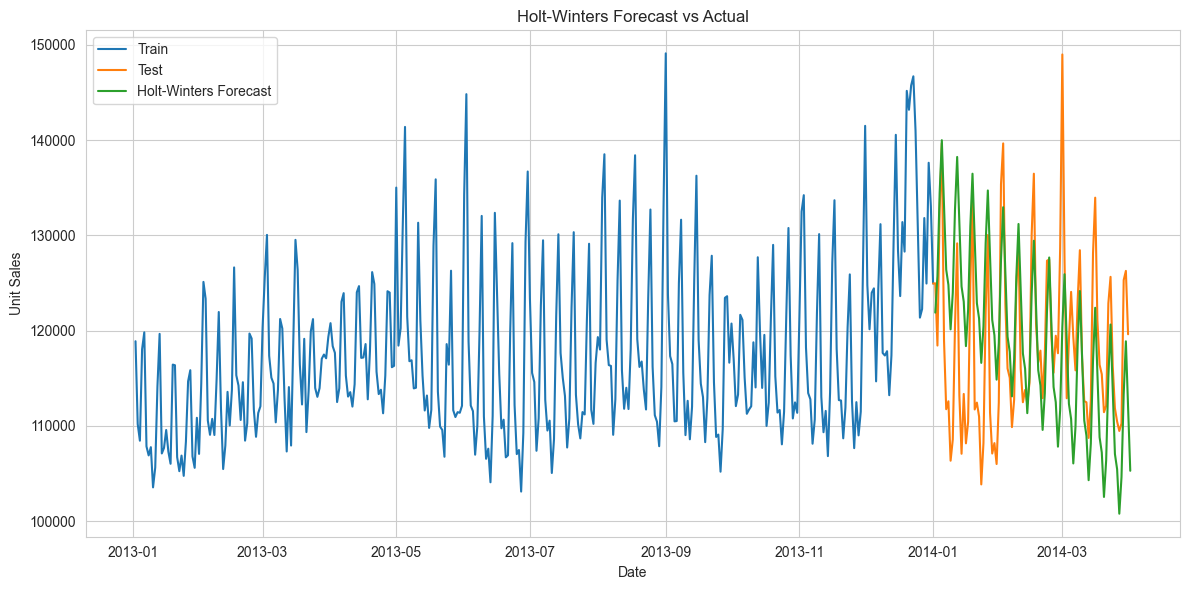

In [19]:
#Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train", color="#1f77b4")
plt.plot(test.index, test, label="Test", color="#ff7f0e")
plt.plot(hw_forecast.index, hw_forecast, label="Holt-Winters Forecast", color="#2ca02c")
plt.legend()
plt.title("Holt-Winters Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

We are seeing some clear improvements in % error from Naive to Holt-Winter models. R2 indicates there is still some work to do with both models performing poorly compared to simply using the mean. The Holt-Winter model is better capturing seasonality but not so much the trend.